In [1]:
from active_learning.util_classes import (
    DimensionlessDataset,
    DimensionlessAnnotationUnit,
    DimensionlessIndex
)
from active_learning.agent import ActiveLearningAgent
from active_learning.selector import DimensionlessSelector
from active_learning.acquisition import MaximumEntropyAcquisition, LowestConfidenceAcquisition, RandomBaselineAcquisition
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import time
import pylab as pl
from IPython import display

In [2]:
def generate_dataset():
    pre_sigma_1 = np.array([[100, 44], [3, 11]])
    sigma_1 = pre_sigma_1 + pre_sigma_1.T
    cluster_1 = np.random.multivariate_normal([0, 5], sigma_1, size = 200)
    cluster_1 = np.concatenate([cluster_1.T, np.ones(200).reshape(1, 200)]).T

    pre_sigma_2 = np.array([[70, -25], [-3, 6]])
    sigma_2 = pre_sigma_2 + pre_sigma_2.T
    cluster_2 = np.random.multivariate_normal([20, 16], sigma_2, size = 200)
    cluster_2 = np.concatenate([cluster_2.T, 2*np.ones(200).reshape(1, 200)]).T

    pre_sigma_3 = np.array([[50, 5.5], [3, 10]])
    sigma_3 = pre_sigma_3 + pre_sigma_3.T
    cluster_3 = np.random.multivariate_normal([-15, 12], sigma_3, size = 200)
    cluster_3 = np.concatenate([cluster_3.T, 3*np.ones(200).reshape(1, 200)]).T
    
    mixed = np.concatenate([cluster_1, cluster_2, cluster_3])
    np.random.shuffle(mixed)
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal', 'box')
    ax.scatter(mixed[:,0], mixed[:,1], c=mixed[:,2], s=4)
    
    np.savetxt("classification_dataset", mixed, delimiter=',')
    
def get_data_from_index(i):
    arr = pd.read_csv('classification_dataset', header = None).to_numpy()
    return torch.tensor(arr[i, :2])

def get_label_from_index(i):
    arr = pd.read_csv('classification_dataset', header = None).to_numpy()
    class_ = int(arr[i, 2])
    return torch.tensor([1 if j == class_-1 else 0 for j in range(3) ])

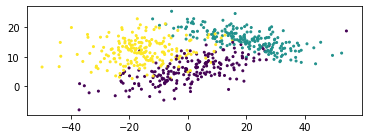

In [3]:
num_datapoints = 200*3
generate_dataset()

all_data = range(num_datapoints)
all_labels = range(num_datapoints)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels)

In [4]:
class MulticlassNN(nn.Module):
    
    def __init__(self, input_dim=2, num_classes=3):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x, anneal = None):
        x = x.float()
        psi = self.linear(x)
        return {"last_preds": nn.functional.log_softmax(psi, dim = 1)}

In [5]:
class Criterion(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, pred_log_probs, target_probs, self_supervision_mask):
        # loss of size [batch, length, classes]
        loss = - pred_log_probs * target_probs
        loss *= self_supervision_mask
        # loss of size [batch, length]
        return loss.sum()

In [6]:
def train_epoch(model, agent, optimiser, criterion):
    
    for idx, batch_indices in enumerate(agent.labelled_set):
        
        model.eval()
        X_batch, y_batch, _, ssm = agent.train_set.get_batch(batch_indices, labels_important=True)
        model.train()
        X_batch.float()
        
        optimiser.zero_grad()
        output = model(X_batch)["last_preds"]
        
        loss = criterion(output, y_batch, ssm)
        loss.backward()
        optimiser.step()

In [7]:
round_size = 5
batch_size = 16
device = 'cpu'

helper = None
model = MulticlassNN()

train_set = DimensionlessDataset(
    data=X_train, labels=y_train, index_class=DimensionlessIndex, semi_supervision_multiplier=0.2,
    data_reading_method=get_data_from_index, label_reading_method=get_label_from_index
)
val_set = DimensionlessDataset(
    data=X_test, labels=y_test, index_class=DimensionlessIndex, semi_supervision_multiplier=0.2,
    data_reading_method=get_data_from_index, label_reading_method=get_label_from_index
)

selector = DimensionlessSelector(
    round_size=round_size, 
    acquisition = RandomBaselineAcquisition(train_set),
    window_class=DimensionlessAnnotationUnit
)

In [8]:
agent = ActiveLearningAgent(
    train_set=train_set,
    selector_class=selector,
    round_size=round_size,
    batch_size=batch_size,
    helper=helper,
    device=device,
    model=model,
    propagation_mode=0,
)

agent.init(int(len(train_set) * 0.05))
print(sum(agent.train_set.index.labelled_idx.values()))

100%|██████████| 450/450 [00:00<00:00, 284681.27it/s]

22


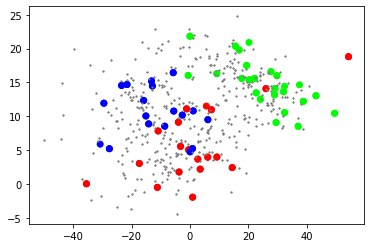

100%|██████████| 450/450 [00:00<00:00, 509567.17it/s]


0 words branched to
158.0ast 5/5 words branched to


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

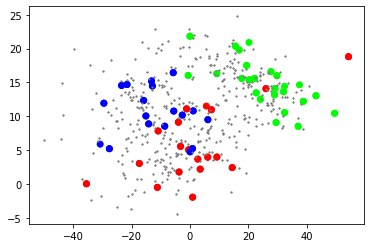

In [10]:
lr = 0.001
num_epoch = 10
criterion = Criterion()
optimiser = optim.SGD(model.parameters(), lr = lr)

for _ in agent:
    print(agent.budget)
    for epoch in range(num_epoch):
        train_epoch(model, agent, optimiser, criterion)
    
    all_labelled_list = []
    for _batch_idx in agent.labelled_set:
        all_labelled_list.extend(_batch_idx)
        
    all_unlabelled_list = []
    for _u_batch_idx in agent.unlabelled_set:
        all_unlabelled_list.extend(_u_batch_idx)
        
    labelled_data, labels, _, _ = agent.train_set.get_batch(all_labelled_list, labels_important = True)
    unlabelled_data, _, _, _ = agent.train_set.get_batch(all_unlabelled_list, labels_important = False)
    
    pl.scatter(labelled_data[:,0], labelled_data[:,1] , c = labels)
    pl.scatter(unlabelled_data[:,0], unlabelled_data[:,1] , c = "grey", s = 1)
    display.clear_output(wait = True)
    display.display(pl.gcf())
    time.sleep(1.0)
    

In [11]:
sum(train_set.index.labelled_idx.values())

67